## Import packages here

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime
from apyori import apriori
import re
import sklearn.metrics as metrics
import geopy.distance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



## Load data into Pandas dataframe

In [4]:
df = pd.read_csv(r"./data/202105-divvy-tripdata.csv")
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0F3AE375DEC608D9,classic_bike,5/2/2021 8:21,5/2/2021 9:20,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900960,-87.623777,41.900960,-87.623777,casual
1,43E916C72D4C77B3,electric_bike,5/1/2021 22:15,5/1/2021 22:51,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.901037,-87.623789,41.900775,-87.623852,casual
2,2AAB47362E76AC7F,electric_bike,5/31/2021 0:50,5/31/2021 0:56,Clark St & Grace St,TA1307000127,Clark St & Leland Ave,TA1309000014,41.950929,-87.659147,41.967092,-87.667394,casual
3,344011882FBBB8BD,classic_bike,5/31/2021 7:35,5/31/2021 8:33,Sheridan Rd & Noyes St (NU),604,Sheridan Rd & Noyes St (NU),604,42.058239,-87.677432,42.058239,-87.677432,casual
4,238E58CAB07FA2A8,electric_bike,5/2/2021 16:55,5/2/2021 16:57,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900995,-87.623736,41.900992,-87.623726,casual


## Helper functions

In [5]:
def subtractTime(startStr, endStr):
    startVec = re.split(r'\D+', startStr)
    endVec = re.split(r'\D+', endStr)
    for i in range(5):
        startVec[i] = int(startVec[i])
        endVec[i] = int(endVec[i])
    start = datetime.datetime(startVec[2], startVec[0], startVec[1], startVec[3], startVec[4])
    end = datetime.datetime(endVec[2], endVec[0], endVec[1], endVec[3], endVec[4])
    duration = end-start
    return duration

In [6]:
# takes two sets of latitude and longitude and outputs a distance in miles
def geoDistance(sLat, sLon, eLat, eLon):
    c1 = (sLat, sLon)
    c2 = (eLat, eLon)
    return geopy.distance.distance(c1, c2).miles

In [7]:
def durationInMin(startStr, endStr):
    dur = subtractTime(startStr, endStr)
    return dur.days*24*60 + dur.seconds/60


In [8]:
def rideDistance(stStId, eStId, sLat, sLon, eLat, eLon):
    if stStId == eStId:
        return 0
    else:
        return geoDistance(sLat, sLon, eLat, eLon)

In [36]:
def rideTypeToInt(rType):
    if rType == 'classic_bike':
        return 0
    elif rType == 'electric_bike':
        return 1
    else:
        return 2

## Predict member or casual using ride duration, displacement, and bike type

In [37]:
df["ride_duration"] = df.apply(lambda x: durationInMin(x["started_at"], x["ended_at"]), axis=1)

df["ride_distance"] = df.apply(lambda x: rideDistance(x["start_station_id"], x["end_station_id"], x["start_lat"], x["start_lng"], x["end_lat"], x["end_lng"]), axis=1)

df["ride_type_int"] = df["rideable_type"].apply(rideTypeToInt)

df.head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration,ride_distance,ride_type_int
0,0F3AE375DEC608D9,classic_bike,5/2/2021 8:21,5/2/2021 9:20,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900960,-87.623777,41.900960,-87.623777,casual,59.0,0.000000,0
1,43E916C72D4C77B3,electric_bike,5/1/2021 22:15,5/1/2021 22:51,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.901037,-87.623789,41.900775,-87.623852,casual,36.0,0.000000,1
2,2AAB47362E76AC7F,electric_bike,5/31/2021 0:50,5/31/2021 0:56,Clark St & Grace St,TA1307000127,Clark St & Leland Ave,TA1309000014,41.950929,-87.659147,41.967092,-87.667394,casual,6.0,1.193686,1
3,344011882FBBB8BD,classic_bike,5/31/2021 7:35,5/31/2021 8:33,Sheridan Rd & Noyes St (NU),604,Sheridan Rd & Noyes St (NU),604,42.058239,-87.677432,42.058239,-87.677432,casual,58.0,0.000000,0
4,238E58CAB07FA2A8,electric_bike,5/2/2021 16:55,5/2/2021 16:57,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900995,-87.623736,41.900992,-87.623726,casual,2.0,0.000000,1


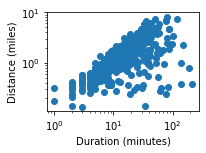

In [38]:
sample_rows = df.sample(500)
sample_rows.plot.scatter(x="ride_duration", y="ride_distance")

ax = plt.subplot(2, 2, 4)
ax.set_yscale('log')
ax.set_xscale('log')
plt.scatter(sample_rows["ride_duration"], sample_rows["ride_distance"])
ax.set_ylabel("Distance (miles)")
ax.set_xlabel("Duration (minutes)")
plt.show()

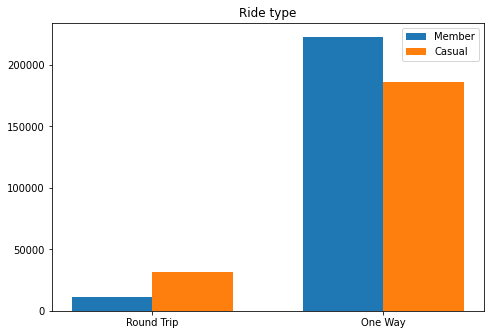

In [69]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# plt.title("Number of Round Trip and One Way Rides")
# langs = ['Round Trip', 'One Way']
# counts = [len(df[df["ride_distance"] == 0]), len(df[df["ride_distance"] != 0])]
# ax.bar(langs,counts)
# plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title("Ride type")
langs = ['Round Trip', 'One Way']  
x = np.arange(len(langs))  # the label locations
width = 0.35  # the width of the bars
counts_mems = [len(df[(df["ride_distance"] == 0) & (df["member_casual"] == "member")]), len(df[(df["ride_distance"] > 0) & (df["member_casual"] == "member")])]
counts_cass = [len(df[(df["ride_distance"] == 0) & (df["member_casual"] != "member")]), len(df[(df["ride_distance"] > 0) & (df["member_casual"] != "member")])]
rects1 = ax.bar(x - width/2, counts_mems, width, label='Member')
rects2 = ax.bar(x + width/2, counts_cass, width, label='Casual')
ax.legend()
ax.set_xticks(x, langs)
plt.show()

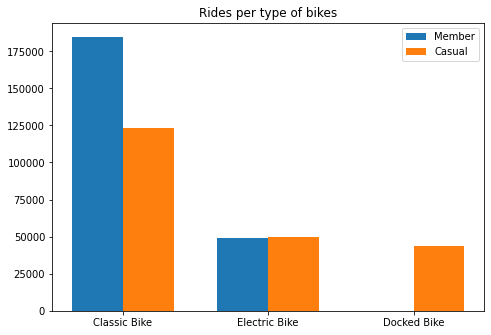

In [65]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title("Rides per type of bikes")
langs = ['Classic Bike', 'Electric Bike', 'Docked Bike']  
x = np.arange(len(langs))  # the label locations
width = 0.35  # the width of the bars
    
counts_mems = [len(df[(df["ride_type_int"] == 0) & (df["member_casual"] == "member")]), len(df[(df["ride_type_int"] == 1) & (df["member_casual"] == "member")]), len(df[(df["ride_type_int"] == 2) & (df["member_casual"] == "member")])]
counts_cass = [len(df[(df["ride_type_int"] == 0) & (df["member_casual"] != "member")]), len(df[(df["ride_type_int"] == 1) & (df["member_casual"] != "member")]), len(df[(df["ride_type_int"] == 2) & (df["member_casual"] != "member")])]
rects1 = ax.bar(x - width/2, counts_mems, width, label='Member')
rects2 = ax.bar(x + width/2, counts_cass, width, label='Casual')
ax.legend()
ax.set_xticks(x, langs)
plt.show()

In [41]:
df_regress_data = df[["ride_distance", "ride_duration", "ride_type_int"]]

X_train, X_test, y_train, y_test = train_test_split(df_regress_data, df["member_casual"], test_size = 0.999)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

clf.score(X_test, y_test)

# df_regress_data.head()

0.6744287737335801

In [48]:
def rt_or_ow(dist):
    return dist > 0

#create new column with calculation of years elite
df["one_way"] = df["ride_distance"].apply(rt_or_ow)

table = pd.crosstab(df['member_casual'], df['one_way'])

print(table)

chi2, p, dof, expected = stats.chi2_contingency(table)
print("chi2 value: " + str(chi2))
print("p value: " + str(p))

one_way        False    True
member_casual               
casual         31293  185529
member         11338  222812
chi2 value: 12095.673648788681
p value: 0.0


In [49]:
table = pd.crosstab(df['member_casual'], df['ride_type_int'])

chi2, p, dof, expected = stats.chi2_contingency(table)
print(table)
print("chi2 value: " + str(chi2))
print("p value: " + str(p))

ride_type_int       0      1      2
member_casual                      
casual         123467  50008  43347
member         184849  49301      0
chi2 value: 54987.82720607011
p value: 0.0


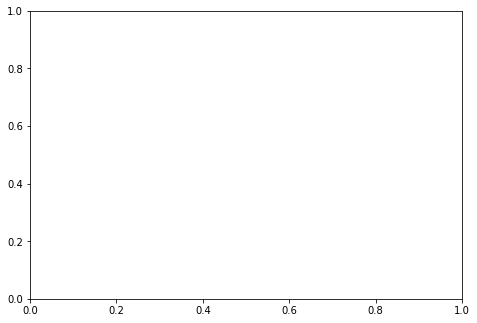

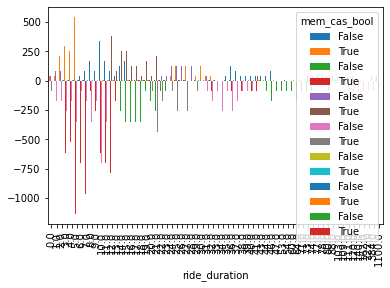

In [84]:
def mem_cas(mem):
    return mem == "member"

#create new column with calculation of years elite
df["mem_cas_bool"] = df["member_casual"].apply(mem_cas)
sample_rows = df.sample(250)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# ax.set_xscale('log')
# plt.scatter(sample_rows["ride_duration"], sample_rows["mem_cas_bool"])
# ax.set_ylabel("Member or casual")
# ax.set_yticks(x, ["Casual", "Member"])
# ax.set_xlabel("Duration (minutes)")
# plt.show()

ag = sample_rows.groupby(['ride_duration','mem_cas_bool']).sum().unstack()
ag.columns = ag.columns.droplevel()

ag.plot(kind = 'bar',  width = 1)
plt.show()